# Designing models for CRC cell lines

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import common_data_processing as dphelp
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
from pymc3_models import crc_models
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 914
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data = pd.read_csv(Path("..", "modeling_data", "depmap_CRC_data.csv"), low_memory=False)

N_GENES = 100
random_genes = np.random.choice(data.hugo_symbol.unique(), N_GENES)

data = (
    data[data.hugo_symbol.isin(random_genes)]
    .sort_values(["depmap_id", "hugo_symbol", "sgrna"])
    .reset_index(drop=True)
)

cat_cols = ["sgrna", "depmap_id", "hugo_symbol"]
for col in cat_cols:
    data = dphelp.make_cat(data, col, ordered=True, sort_cats=False)

data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,ATTGGTAGAACTTAGTCCAG,ls513-311cas9_repa_p6_batch2,-0.328006,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.976114,1.654121,0,False,NaN,NaN,NaN,NaN,False,5.14527
1,ATTGGTAGAACTTAGTCCAG,ls513-311cas9_repb_p6_batch2,-0.233740,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.976114,1.654121,0,False,NaN,NaN,NaN,NaN,False,5.14527
2,GATCTGCTGACCCAATGCTA,ls513-311cas9_repa_p6_batch2,-0.125088,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.976114,1.654121,0,False,NaN,NaN,NaN,NaN,False,5.14527
3,GATCTGCTGACCCAATGCTA,ls513-311cas9_repb_p6_batch2,-0.084501,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.976114,1.654121,0,False,NaN,NaN,NaN,NaN,False,5.14527
4,GATGACTTCCCAGAATCTAC,ls513-311cas9_repa_p6_batch2,0.306206,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,0.976114,1.654121,0,False,NaN,NaN,NaN,NaN,False,5.14527


## Models

### Model 1

$
lfc \sim N(\mu, \sigma) \\
\mu = \alpha_g \\
\quad \alpha_g \sim N(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha \sim N(0, 5) \quad \sigma_\alpha \sim \text{Exp}(2) \\
\sigma \sim HN(5)
$

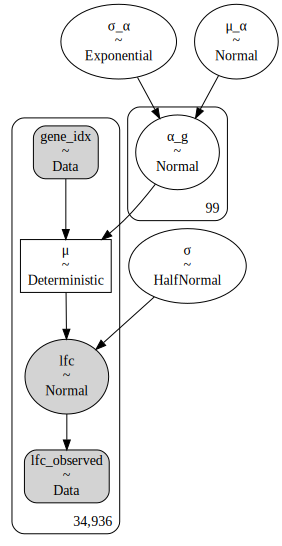

In [3]:
gene_idx = dphelp.get_indices(data, "hugo_symbol")
m1 = crc_models.model_1(gene_idx=gene_idx, lfc_data=data.lfc.values)

pm.model_to_graphviz(m1)

In [4]:
with m1:
    trace = pm.sample(
        draws=1000,
        init="advi",
        n_init=200000,
        tune=1000,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 29100
Interrupted at 29,099 [14%]: Average Loss = 35,555
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, α_g, σ_α, μ_α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


### Model 2

$
lfc \sim N(\mu, \sigma) \\
\mu = \alpha_s \\
\quad \alpha_s \sim N(\mu_\alpha, \sigma_\alpha) \\
\qquad \mu_\alpha \sim N(\mu_g, \sigma_g) \quad \sigma_\alpha \sim \text{Exp}(2) \\
\qquad \quad \mu_g \sim N(0, 5) \quad \sigma_g \sim \text{Exp}(2) \\
\sigma \sim HN(5)
$

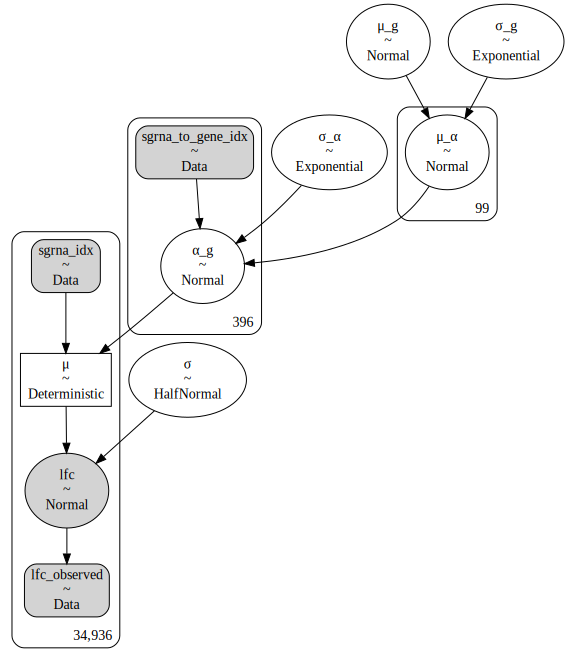

In [5]:
sgrna_to_gene_map = (
    data[["sgrna", "hugo_symbol"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values("sgrna")
    .reset_index(drop=True)
)

sgrna_to_gene_idx = dphelp.get_indices(sgrna_to_gene_map, "hugo_symbol")
sgrna_idx = dphelp.get_indices(data, "sgrna")

m2 = crc_models.model_2(
    sgrna_idx=sgrna_idx, sgrna_to_gene_idx=sgrna_to_gene_idx, lfc_data=data.lfc.values
)

pm.model_to_graphviz(m2)

In [6]:
with m2:
    trace = pm.sample(
        draws=1000,
        init="advi",
        n_init=200000,
        tune=1000,
        random_seed=RANDOM_SEED,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 30200
Interrupted at 30,199 [15%]: Average Loss = 32,432
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, α_g, σ_α, μ_α, σ_g, μ_g]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


---

In [7]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.52 minutes


In [8]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-02-16

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: crc

arviz     : 0.11.1
pandas    : 1.2.2
pymc3     : 3.11.1
plotnine  : 0.7.1
re        : 2.2.1
seaborn   : 0.11.1
theano    : 1.0.5
matplotlib: 3.3.4
numpy     : 1.20.1

